In [1]:
import jax
import optax
import numpy as np
import seaborn as sns
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
from typing import Callable
from functools import partial
from jax.flatten_util import ravel_pytree
from rebayes.utils.rotating_mnist_data import load_rotated_mnist, load_mnist

from rebayes import base
from rebayes.low_rank_filter import lofi
from rebayes.sgd_filter import replay_sgd as rsgd
from rebayes.utils.utils import tree_to_cpu, get_subtree

In [2]:
%load_ext autoreload
%autoreload 2

In [18]:
a  = np.array([1, 2, 3])
print(a.shape)
b = np.expand_dims(a, axis=1).T
print(b.shape)
c = np.repeat(b, 4, axis=0)
print(c)

(3,)
(1, 3)
[[1 2 3]
 [1 2 3]
 [1 2 3]
 [1 2 3]]


In [3]:
%config InlineBackend.figure_format = "retina"

In [10]:
class MLP(nn.Module):
    n_out: int = 1
    n_hidden: int = 100
    activation: Callable = nn.elu

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out, name="last-layer")(x)
        #x = nn.sigmoid(x)
        return x

In [3]:
def load_data(
    anglefn: Callable,
    sort_by_angle: bool = True,
    target_digit = [3, 2],
    num_train = 1000,
    num_test = 1000,
):
    data = load_rotated_mnist(
        anglefn, target_digit=target_digit, sort_by_angle=sort_by_angle, num_train=num_train, num_test=num_test,
    )
    train, test = data
    X_train, y_train, labels_train = train
    X_test, y_test, labels_test = test
    labels_train, labels_test = jnp.array(labels_train), jnp.array(labels_test)

    # angles
    ymean, ystd = y_train.mean().item(), y_train.std().item()
    if ystd > 0:
        y_train = (y_train - ymean) / ystd
        y_test = (y_test - ymean) / ystd

    dataset = {
        "train": (X_train, y_train, labels_train),
        "test": (X_test, y_test, labels_test),
    }

    res = {
        "dataset": dataset,
        "ymean": ymean,
        "ystd": ystd,
    }

    return res

In [4]:
def damp_angle(n_configs, minangle, maxangle):
    t = np.linspace(-0.5, 1.5, n_configs)
    
    angles = np.exp(t) * np.sin(55 * t)
    angles = np.sin(55 * t)
    
    angles = (angles + 1) / 2 * (maxangle - minangle) + minangle + np.random.randn(n_configs) * 2
    
    # angles = np.random.randn(n_configs) / 100
    # angles = np.abs(angles)
    
    return angles

def constant_angle(n_configs, minangle, maxangle, angle=0.0):
    return np.ones(n_configs) * angle


In [5]:
cangle = partial(constant_angle, angle=90)
angles = cangle(10, 0, 180)
print(angles)


angles = damp_angle(10, 0, 180)
print(angles)

[90. 90. 90. 90. 90. 90. 90. 90. 90. 90.]
[ 26.64928085  51.32416842  84.98771575 114.8934901  143.82838514
 162.2826197  178.5420673  182.51566739 173.57811967 158.26904521]


(1000, 784) (1000, 784) (1000,) (1000,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0 1 1 1 1 0 1 1 0 0] [[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


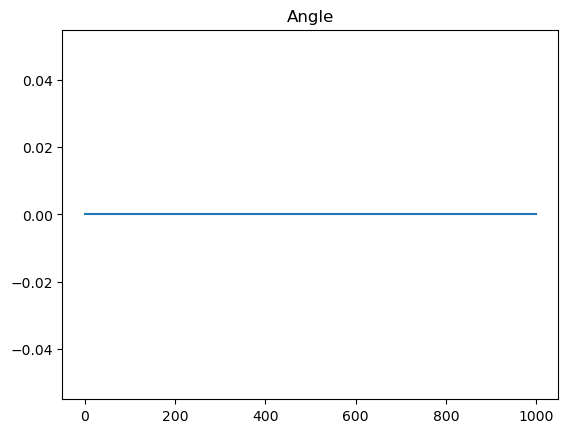

In [28]:
classes = [0,1,2,3,4,5]
classes = [0, 1]
nclasses = len(classes)
#data = load_data(damp_angle, sort_by_angle=False, target_digit=classes, num_train = 1000, num_test = 1000)
data = load_data(partial(constant_angle, angle=0), sort_by_angle=False, target_digit=classes, num_train = 1000, num_test = 1000)

X_train, angle_train, labels_train = data["dataset"]["train"]
X_test, angle_test, labels_test = data["dataset"]["test"]

# For binary classification
#Y_train = jnp.array(labels_train) == 2
#Y_test = jnp.array(labels_test) == 2
Y_train, Y_test = labels_train, labels_test

Y_train = jax.nn.one_hot(Y_train, nclasses)
Y_test = jax.nn.one_hot(Y_test, nclasses)

print(X_train.shape, X_test.shape, labels_train.shape, labels_test.shape)
print(angle_train[:10], labels_train[:10], Y_train[:10])

plt.title("Angle")
plt.plot(angle_train)

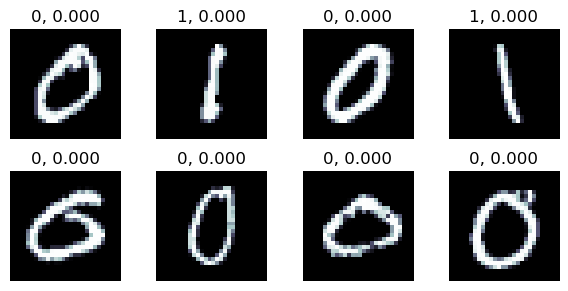

In [29]:
def plot_images(X_train, y_train, labels_train):
    #np.random.seed(314)
    #ixs = np.random.randint(0, len(X_train), size=8)
    ixs = np.arange(8)
    fig, axs = plt.subplots(2, 4, figsize=(6, 3))
    axs = axs.ravel()
    for ax, ix in zip(axs, ixs):
        img = X_train[ix]
        y = y_train[ix]
        label = labels_train[ix]
        ax.imshow(img.reshape(28, 28), cmap="bone")
        ax.axis("off")
        ax.set_title('{}, {:0.3f}'.format(label, y))
    plt.tight_layout()

ixs = np.arange(start=0, stop=800, step=100)
plot_images(X_train[ixs], angle_train[ixs], labels_train[ixs])

In [35]:
def make_bnn_flax(dim_in, dim_out, nhidden=50):
    key = jax.random.PRNGKey(314)
    model = MLP(dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

def apply_fn_flat(flat_params, x, model, recfn):
    return model.apply(recfn(flat_params), x)

def apply_fn_unflat(params, x, model):
    return model.apply(params, x)


dim_out = nclasses
_, dim_in = data["dataset"]["train"][0].shape
model, dnn_params, flat_params, recfn = make_bnn_flax(dim_in, dim_out)

In [40]:
def callback(bel, pred_obs, t, X, y, bel_pred, apply_fn, store_fro=True, **kwargs):
    X_train, y_train, X_test, y_test, forecast = kwargs["X_train"], kwargs["y_train"], kwargs["X_test"], kwargs["y_test"], kwargs["forecast"]
    
    slice_ix = jnp.arange(0, forecast) + t
    X_forecast = jnp.take(X_train, slice_ix, axis=0, fill_value=0)
    y_forecast = jnp.take(y_train, slice_ix, axis=0, fill_value=0)
    y_forecast = y_forecast.argmax(axis=1)
    
    y_next = y.ravel()
    phat_next = pred_obs.ravel()
    yhat_next = phat_next.argmax()
    err = (y_next == yhat_next).mean()

    #yhat_test = apply_fn(bel.mean, X_test).squeeze().round()
    logits_test = apply_fn(bel.mean, X_test)
    yhat_test = logits_test.argmax(axis=1)
    err_test = (y_test.argmax(axis=1) == yhat_test).mean()

    #yhat_forecast = apply_fn(bel.mean, X_forecast).squeeze().round()
    logits_forecast = apply_fn(bel.mean, X_forecast)
    yhat_forecast = logits_forecast.argmax(axis=1)
    err_forecast = (y_forecast == yhat_forecast).mean()
    
    res = {
        "forecast-error": err_forecast,
        "test-error": err_test,
        "osa-error": err,
    }
    return res

In [41]:

emission_mean_function=lambda w, x: jax.nn.softmax(apply_fn_flat(w, x, model, recfn))
def emission_cov_function(w, x):
    ps = emission_mean_function(w, x)
    return jnp.diag(ps) - jnp.outer(ps, ps) + 1e-3 * jnp.eye(len(ps)) # Add diagonal to avoid singularity

ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.1, # 0.01
        dynamics_weights=1,
        dynamics_covariance=0.0,#1e-3,
        emission_mean_function = emission_mean_function,
        emission_cov_function = emission_cov_function,
        dynamics_covariance_inflation_factor=0.0
)

mem = 10
lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False, inflation="hybrid")

In [42]:
%%time
agent = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

ymean, ystd = data["ymean"], data["ystd"]
callback_part = partial(callback,
                        apply_fn=agent.params.emission_mean_function,
                        X_train=X_train, y_train=Y_train,
                        X_test=X_test, y_test=Y_test, forecast=10
                       )

nsteps = 500
bel, outputs = agent.scan(X_train[:nsteps], Y_train[:nsteps], progress_bar=False, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_lofi = tree_to_cpu(outputs)

CPU times: user 10.2 s, sys: 343 ms, total: 10.5 s
Wall time: 4 s


In [43]:
print(outputs_lofi.keys())

dict_keys(['forecast-error', 'osa-error', 'test-error'])


Text(0.5, 1.0, 'lofi, memory size = 10')

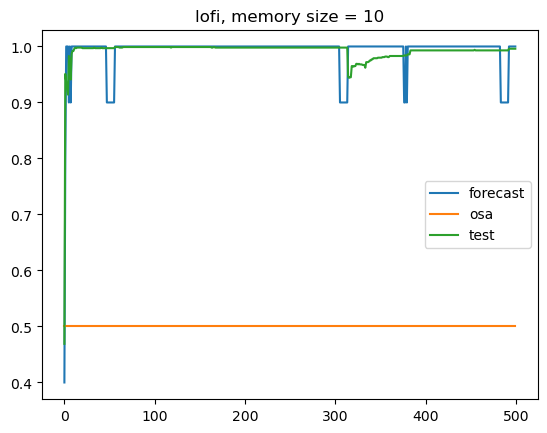

In [44]:
plt.figure()
plt.plot(outputs_lofi["forecast-error"], label="forecast")
plt.plot(outputs_lofi["osa-error"], label="osa")
plt.plot(outputs_lofi["test-error"], label="test")
plt.legend()
plt.title('lofi, memory size = {}'.format(mem))

## Fifo Buffer

In [99]:

@partial(jax.jit, static_argnames=("applyfn",))
def lossfn_crossent_fifo(params, counter, X, y, applyfn):
    
    logits = applyfn(params, X)
    probs = jax.nn.softmax(logits)
    #probs = jax.nn.sigmoid(logits)
    
    nll = -y * jnp.log(probs)
    nll = nll.sum(axis=-1)
    loss = (nll * counter).sum() / counter.sum()
    return loss


In [100]:
%%time
lr, buffer = 5e-4, 10
agent = rsgd.FifoSGD(lossfn_crossent_fifo, 
                    apply_fn=partial(apply_fn_unflat, model=model),
                    init_params = dnn_params,
                    tx = optax.adam(learning_rate=lr),
                    buffer_size=buffer,
                    dim_features=X_train.shape[1],
                    dim_output=1,
                    n_inner=1)


callback_part = partial(callback,
                        apply_fn=agent.apply_fn,
                        X_train=X_train, y_train=Y_train,
                        X_test=X_test, y_test=Y_test, forecast=10
                       )

bel, outputs = agent.scan(X_train[:nsteps], Y_train[:nsteps], progress_bar=False, callback=callback_part)
bel = jax.block_until_ready(bel)
outputs_rsgd_adam = tree_to_cpu(outputs)



CPU times: user 1.74 s, sys: 6.71 ms, total: 1.75 s
Wall time: 1.23 s


Text(0.5, 1.0, 'SGD Replay (Adam), buffer 10, lr 0.00')

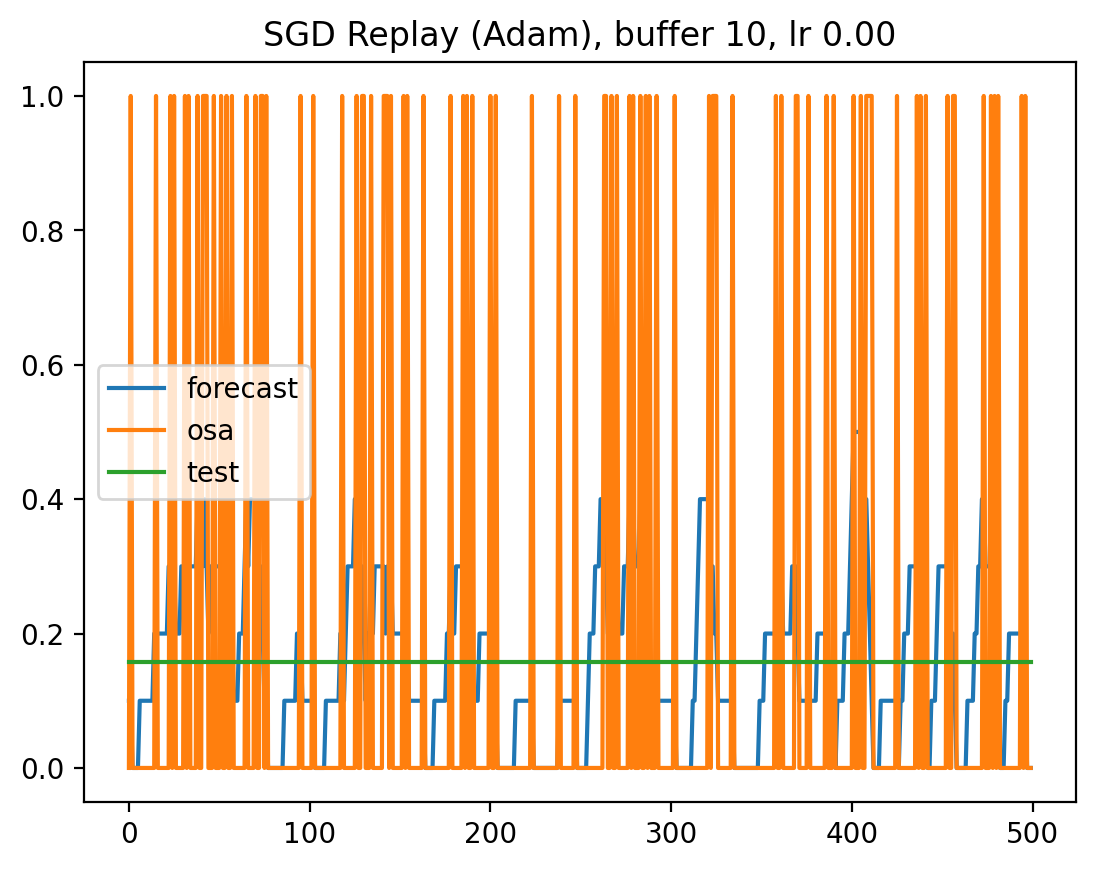

In [101]:
plt.figure()
plt.plot(outputs_rsgd_adam["forecast-error"], label="forecast")
plt.plot(outputs_rsgd_adam["osa-error"], label="osa")
plt.plot(outputs_rsgd_adam["test-error"], label="test")
plt.legend()
plt.title('SGD Replay (Adam), buffer {}, lr {:0.2f}'.format(buffer, lr))